<a href="https://colab.research.google.com/github/elvirasru/translator-esp-eng/blob/main/DP_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from google.colab import drive
from numpy import array, argmax, random, take
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, Dropout, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers

pd.set_option('display.max_colwidth', 200)

Functions

In [ ]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq


def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None


def fit_model(model, X, Y, x_test, y_test, epochs, batch_size, file_name):
  checkpoint = ModelCheckpoint(file_name, verbose=1, save_best_only=True, mode='min')

  start = datetime.now()
  history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[checkpoint], verbose=1)
  
  duration = datetime.now() - start
  print("Training completed in time: ", duration)
  return history


def model_plot_validation(history):

  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 6))

  ax0.set_title('Accuracy')
  ax0.plot(history.history['acc'])
  ax0.plot(history.history['val_acc'])
  ax0.legend(['train','validation'])

  ax1.set_title('Loss')
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.legend(['train','validation'])


################################ Models ################################

def build_basic_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units, layer):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) 
    model.add(layer(units))
    model.add(RepeatVector(out_timesteps))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

def build_basic_model_with_drop_out(in_vocab, out_vocab, in_timesteps, out_timesteps, units, layer, drop_out):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) 
    model.add(layer(units))
    model.add(Dropout(drop_out))
    model.add(RepeatVector(out_timesteps))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units, layer1, layer2):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) 
    model.add(layer1(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(layer2(units))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

def build_model_with_dropout(in_vocab, out_vocab, in_timesteps, out_timesteps, units, layer1, layer2, drop_out):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) 
    model.add(layer1(units))
    model.add(Dropout(drop_out))
    model.add(RepeatVector(out_timesteps))    
    model.add(layer2(units))
    model.add(Dropout(drop_out))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

# Read Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Load data from google drive:

In [ ]:
eng_spa_df = pd.read_table("/content/drive/MyDrive/RNN/data/spa.txt", names=["English", "Spanish"], usecols=[0,1])

Now we may check that the file was properly loaded, so let's see the first and the last rows:

In [ ]:
eng_spa_df.head(3)

,English,Spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.


In [ ]:
eng_spa_df.tail(3)

,English,Spanish
122933,"Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Goo...","Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a ..."
122934,"If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until t...","Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra ..."
122935,"It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages r...","Puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboración. Sin embargo, si animamos a los miembros a contribuir frase..."


As we can see the first column contains all the English sentences meanwhile the second column constains the same sentences but in Spanish.

In [ ]:
print("There are a total of %d pairs of sentences" %eng_spa_df.shape[0])

There are a total of 122936 pairs of sentences


## Text Pre-Processing

### 1. Text Cleaning

To clean data, we will get rid of the punctuation marks, and convert the text to lower case:

Making use of the "string" library we may find the constant "punctuation" which will include all the puctuation we want to remove (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~). But, as we are working with Spanish sentences we will have to include these two extra punctuations "¡¿" which are used for building Spanish sentences.

In [ ]:
punctuation = string.punctuation + "¿¡"

In [ ]:
eng_spa_df = eng_spa_df.applymap(lambda x : x.translate(str.maketrans('', '', punctuation)).lower())

Here we may check the result:

In [ ]:
eng_spa_df

,English,Spanish
0,go,ve
1,go,vete
2,go,vaya
3,go,váyase
4,hi,hola
...,...,...
122931,there are mothers and fathers who will lie awake after the children fall asleep and wonder how theyll make the mortgage or pay their doctors bills or save enough for their childs college education,hay madres y padres que se quedan despiertos después de que sus hijos se hayan dormido y se preguntan cómo conseguir pagar la hipoteca o las facturas del médico o cómo ahorrar el suficiente dinero...
122932,a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities some people try to reduce their carbon footprint because they are concerned about climate...,una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades algunas personas intentan reducir su huella de carbono porque están...
122933,since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google...,como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes simplemente voy a la...
122934,if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until th...,si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra v...


### 2. Text to Sequence Conversion


With a view to building our model we need to convert our text into numeric tensors as this is the input that is neededed for deep-learning models.

First of all, we need to examine which is the length of our sentences. Let's save this information in two new columns:

In [ ]:
eng_spa_df["eng_length"] = eng_spa_df.English.apply(lambda x : len(x.split()))
eng_spa_df["spa_length"] = eng_spa_df.Spanish.apply(lambda x : len(x.split()))

In [ ]:
print("The longest sentence in English contains " + str(eng_spa_df.eng_length.max()) + " words.")
print("The longest sentence in Spanish contains " + str(eng_spa_df.spa_length.max()) + " words.")

The longest sentence in English contains 47 words.
The longest sentence in Spanish contains 53 words.


We may also visualize how many sentences there are of each length:

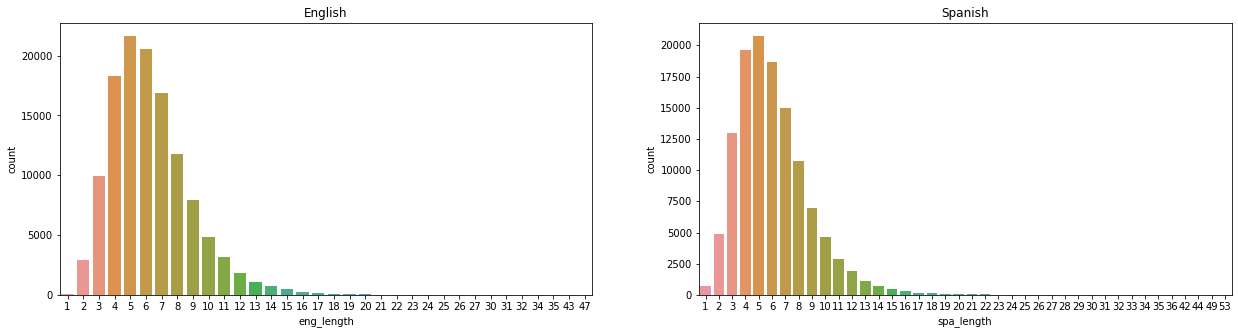

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols= 2, figsize= (21, 5))

sns.countplot(ax=ax0, x="eng_length", data=eng_spa_df)
ax0.set_title("English")

sns.countplot(ax=ax1, x="spa_length", data=eng_spa_df)
ax1.set_title("Spanish");

Second, let's map each word with a numeric value. To do this we will use a Tokenizer:

In [ ]:
eng_tokenizer = tokenization(eng_spa_df.English)
spa_tokenizer = tokenization(eng_spa_df.Spanish)

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
spa_vocab_size = len(spa_tokenizer.word_index) + 1

print('English Vocabulary Size: %d' % eng_vocab_size)
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

English Vocabulary Size: 13731
Spanish Vocabulary Size: 26506


This would be the resultant mapping:

In [ ]:
 print(eng_tokenizer.word_index)
 print(spa_tokenizer.word_index)

{'the': 1, 'i': 2, 'to': 3, 'you': 4, 'tom': 5, 'a': 6, 'is': 7, 'he': 8, 'in': 9, 'of': 10, 'that': 11, 'it': 12, 'was': 13, 'do': 14, 'this': 15, 'me': 16, 'my': 17, 'have': 18, 'for': 19, 'dont': 20, 'she': 21, 'are': 22, 'what': 23, 'mary': 24, 'his': 25, 'your': 26, 'we': 27, 'on': 28, 'be': 29, 'with': 30, 'want': 31, 'im': 32, 'not': 33, 'and': 34, 'like': 35, 'know': 36, 'at': 37, 'him': 38, 'can': 39, 'go': 40, 'her': 41, 'has': 42, 'its': 43, 'there': 44, 'they': 45, 'will': 46, 'were': 47, 'time': 48, 'how': 49, 'very': 50, 'did': 51, 'as': 52, 'all': 53, 'had': 54, 'about': 55, 'didnt': 56, 'here': 57, 'up': 58, 'think': 59, 'get': 60, 'out': 61, 'cant': 62, 'if': 63, 'from': 64, 'when': 65, 'an': 66, 'one': 67, 'no': 68, 'going': 69, 'by': 70, 'doesnt': 71, 'why': 72, 'would': 73, 'youre': 74, 'good': 75, 'come': 76, 'see': 77, 'please': 78, 'ill': 79, 'who': 80, 'just': 81, 'need': 82, 'been': 83, 'so': 84, 'help': 85, 'more': 86, 'tell': 87, 'than': 88, 'but': 89, 'now':

# Building the Model

Data needs to be splitted into test and train so that we are able to test our model with unknow data for him.

In [ ]:
train, test = train_test_split(eng_spa_df.iloc[:,0:2], test_size=0.2, random_state = 12)

Even though we have mapped data from text to numeric values, it still does not have the proper format for our neuronal network. We need to transform this data into a numeric tensor. To do this, let's convert each array of numers into a new array with the same lentgh than the others. As the longest sentence has 53 word, then we have to pad with 0 each array until we meet that length.

In [ ]:
spa_length = 53
eng_length = 53

In [ ]:
trainX = encode_sequences(spa_tokenizer, spa_length, train.Spanish)
trainY = encode_sequences(eng_tokenizer, eng_length, train.English)

[[  103    54    30 ...     0     0     0]
 [    6  1118 14694 ...     0     0     0]
 [    3   121  4191 ...     0     0     0]
 ...
 [   58   303  2338 ...     0     0     0]
 [    3   269   789 ...     0     0     0]
 [   21   124  1799 ...     0     0     0]]
98348
[[  44   22   86 ...    0    0    0]
 [8196 1181    7 ...    0    0    0]
 [   2   56   31 ...    0    0    0]
 ...
 [  74  470  836 ...    0    0    0]
 [   2  219   68 ...    0    0    0]
 [  17  156 1081 ...    0    0    0]]
98348


In [ ]:
testX = encode_sequences(spa_tokenizer, spa_length, test.Spanish)
testY = encode_sequences(eng_tokenizer, eng_length, test.English)

[[  23   56 4602 ...    0    0    0]
 [  11  165  239 ...    0    0    0]
 [   9  196    2 ...    0    0    0]
 ...
 [  14  132   16 ...    0    0    0]
 [  24  253   15 ...    0    0    0]
 [ 501  908  113 ...    0    0    0]]
24588
[[  21   42 3163 ...    0    0    0]
 [ 161   35    3 ...    0    0    0]
 [   8    7  224 ...    0    0    0]
 ...
 [   8   54    6 ...    0    0    0]
 [  21  150  532 ...    0    0    0]
 [   2  291    2 ...    0    0    0]]
24588


Here we may see an example of how the sentence have been mapped to a new numeric sentence of length 53:

In [ ]:
train.Spanish.iloc[0,], trainX[0]

('hoy hay más nubes que ayer',
 array([ 103,   54,   30, 2133,    2,  141,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

In [ ]:
train.English.iloc[0,], trainY[0]

('there are more clouds today than there were yesterday',
 array([  44,   22,   86, 1871,  134,   88,   44,   47,  184,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

To build our model we will try using some recurrents layers such as **SimpleRNN**, **LSTM** and **GRU**.

## Model SimpleRNN

SimpleRNN isn’t good at processing long sequences, such as text.

As a first step we are going to create a simple model. It will only have a first embedding layer and a SimpleRNN layer:

In [ ]:
model_simple_rnn_1 = build_basic_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 32, lambda x : SimpleRNN(x))

model_simple_rnn_1.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_simple_rnn_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 32)            848192    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 53, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 53, 13731)         453123    
Total params: 1,303,395
Trainable params: 1,303,395
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_simple_rnn_1 = fit_model(model_simple_rnn_1, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.SimpleRNN.1.30_jan_21')

Epoch 1/30
193/193 [==============================] - 107s 549ms/step - loss: 6.1897 - acc: 0.8057 - val_loss: 1.1834 - val_acc: 0.8812

Epoch 00001: val_loss improved from inf to 1.18339, saving model to model.SimpleRNN.1.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.1.30_jan_21/assets
Epoch 2/30
193/193 [==============================] - 105s 547ms/step - loss: 1.1663 - acc: 0.8807 - val_loss: 1.1403 - val_acc: 0.8812

Epoch 00002: val_loss improved from 1.18339 to 1.14031, saving model to model.SimpleRNN.1.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.1.30_jan_21/assets
Epoch 3/30
193/193 [==============================] - 106s 547ms/step - loss: 1.1369 - acc: 0.8811 - val_loss: 1.1347 - val_acc: 0.8812

Epoch 00003: val_loss improved from 1.14031 to 1.13467, saving model to model.SimpleRNN.1.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.1.30_jan_21/assets
Epoch 4/30
193/193 [==============================] - 105s 546ms/step - loss: 1.130

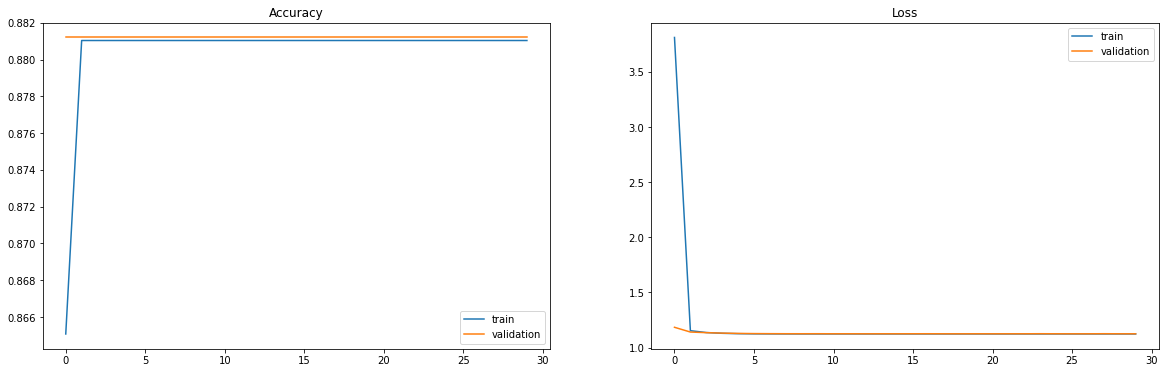

In [ ]:
model_plot_validation(history_simple_rnn_1)

In [ ]:
score = model_simple_rnn_1.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_simple_rnn_1.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.8810375928878784
Training Loss:  1.1217787265777588
Testing Accuracy:  0.8812029957771301
Testing Loss:  1.1243332624435425


As we may see from the result, this model isn't good enough as the loss is a bit high. Besides, the performance does not improve with each epoch.

Let's try the same model but now with more units.



In [ ]:
model_simple_rnn_2 = build_basic_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, lambda x : SimpleRNN(x))

model_simple_rnn_2.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_simple_rnn_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 53, 512)           13571072  
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 512)               524800    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 53, 512)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 53, 13731)         7044003   
Total params: 21,139,875
Trainable params: 21,139,875
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_simple_rnn_2 = fit_model(model_simple_rnn_2, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.SimpleRNN.2.30_jan_21')

Epoch 1/30
193/193 [==============================] - 191s 985ms/step - loss: 1.9362 - acc: 0.8498 - val_loss: 1.1722 - val_acc: 0.8808

Epoch 00001: val_loss improved from inf to 1.17220, saving model to model.SimpleRNN.2.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.2.30_jan_21/assets
Epoch 2/30
193/193 [==============================] - 191s 990ms/step - loss: 1.1966 - acc: 0.8791 - val_loss: 1.1751 - val_acc: 0.8807

Epoch 00002: val_loss did not improve from 1.17220
Epoch 3/30
193/193 [==============================] - 192s 993ms/step - loss: 1.1510 - acc: 0.8802 - val_loss: 1.1227 - val_acc: 0.8810

Epoch 00003: val_loss improved from 1.17220 to 1.12270, saving model to model.SimpleRNN.2.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.2.30_jan_21/assets
Epoch 4/30
193/193 [==============================] - 191s 993ms/step - loss: 1.0956 - acc: 0.8811 - val_loss: 1.0986 - val_acc: 0.8809

Epoch 00004: val_loss improved from 1.12270 to 1.09862, saving mo

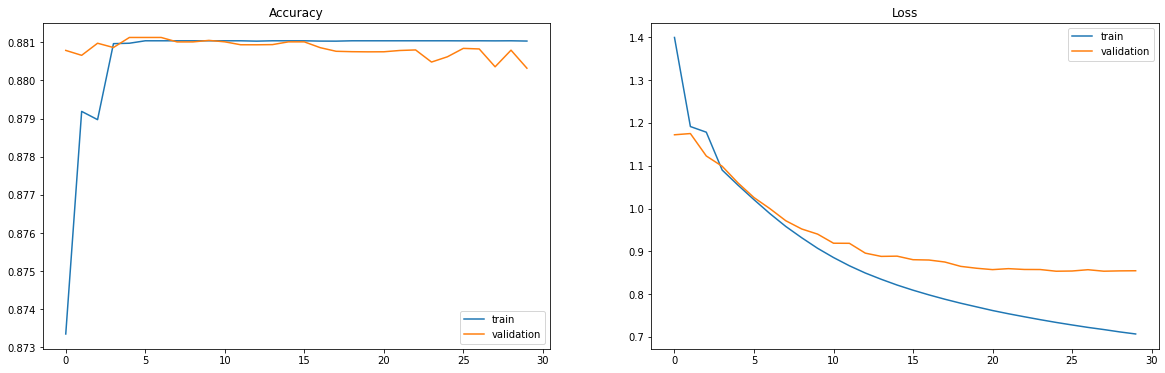

In [ ]:
model_plot_validation(history_simple_rnn_2)

In [ ]:
score = model_simple_rnn_2.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_simple_rnn_2.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.8810141682624817
Training Loss:  0.710140585899353
Testing Accuracy:  0.8803189992904663
Testing Loss:  0.8545860052108765


With this new model we have improved the loss for the train and test data. However, from epoch 5 it starts overfitting.

Let's try a new model adding another SimpleRNN layer:

In [ ]:
model_simple_rnn_3 = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, lambda x : SimpleRNN(x), lambda x: SimpleRNN(x, return_sequences=True))

model_simple_rnn_3.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_simple_rnn_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 512)           13571072  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 512)               524800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 53, 512)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 53, 512)           524800    
_________________________________________________________________
dense (Dense)                (None, 53, 13731)         7044003   
Total params: 21,664,675
Trainable params: 21,664,675
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_simple_rnn_3 = fit_model(model_simple_rnn_3, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.SimpleRNN.3.30_jan_21')

Epoch 1/30
193/193 [==============================] - 90s 445ms/step - loss: 2.0005 - acc: 0.7950 - val_loss: 0.8202 - val_acc: 0.8852

Epoch 00001: val_loss improved from inf to 0.82023, saving model to model.SimpleRNN.3.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.3.30_jan_21/assets
Epoch 2/30
193/193 [==============================] - 85s 442ms/step - loss: 0.8541 - acc: 0.8831 - val_loss: 0.8174 - val_acc: 0.8878

Epoch 00002: val_loss improved from 0.82023 to 0.81736, saving model to model.SimpleRNN.3.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.3.30_jan_21/assets
Epoch 3/30
193/193 [==============================] - 85s 443ms/step - loss: 0.7999 - acc: 0.8888 - val_loss: 0.7222 - val_acc: 0.8933

Epoch 00003: val_loss improved from 0.81736 to 0.72219, saving model to model.SimpleRNN.3.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.3.30_jan_21/assets
Epoch 4/30
193/193 [==============================] - 85s 442ms/step - loss: 0.7748 - 

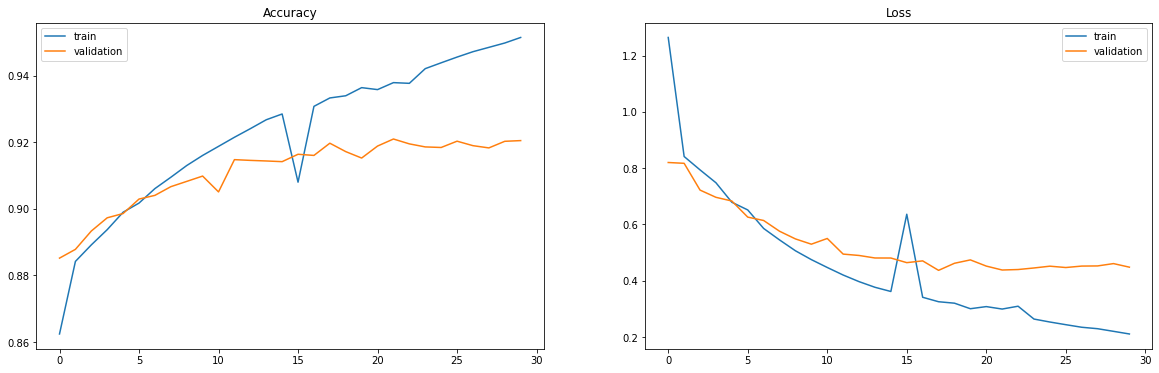

In [ ]:
model_plot_validation(history_simple_rnn_3)

In [ ]:
score = model_simple_rnn_3.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_simple_rnn_3.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.9485049843788147
Training Loss:  0.22237220406532288
Testing Accuracy:  0.9204981327056885
Testing Loss:  0.44808730483055115


As we may see we have improved training and validation accuracy and loss. But, as before, after some epochs the curves starts to diverge.

Let's try to fight overfitting by adding dropout for each layer:



In [ ]:
model_simple_rnn_4 = build_model_with_dropout(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, 
                                 lambda x : SimpleRNN(x), 
                                 lambda x: SimpleRNN(x, return_sequences=True),
                                 0.5)

model_simple_rnn_4.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_simple_rnn_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 512)           13571072  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 53, 512)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 53, 512)           524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 512)           0         
_________________________________________________________________
dense (Dense)                (None, 53, 13731)         7

In [ ]:
history_simple_rnn_4 = fit_model(model_simple_rnn_4, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.SimpleRNN.4.30_jan_21')

Epoch 1/30
193/193 [==============================] - 88s 448ms/step - loss: 1.7044 - acc: 0.8417 - val_loss: 0.7981 - val_acc: 0.8875

Epoch 00001: val_loss improved from inf to 0.79812, saving model to model.SimpleRNN.4.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.4.30_jan_21/assets
Epoch 2/30
193/193 [==============================] - 86s 444ms/step - loss: 0.8506 - acc: 0.8845 - val_loss: 0.7647 - val_acc: 0.8887

Epoch 00002: val_loss improved from 0.79812 to 0.76471, saving model to model.SimpleRNN.4.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.4.30_jan_21/assets
Epoch 3/30
193/193 [==============================] - 86s 444ms/step - loss: 0.8008 - acc: 0.8879 - val_loss: 0.7496 - val_acc: 0.8931

Epoch 00003: val_loss improved from 0.76471 to 0.74962, saving model to model.SimpleRNN.4.30_jan_21
INFO:tensorflow:Assets written to: model.SimpleRNN.4.30_jan_21/assets
Epoch 4/30
193/193 [==============================] - 86s 446ms/step - loss: 0.7596 - 

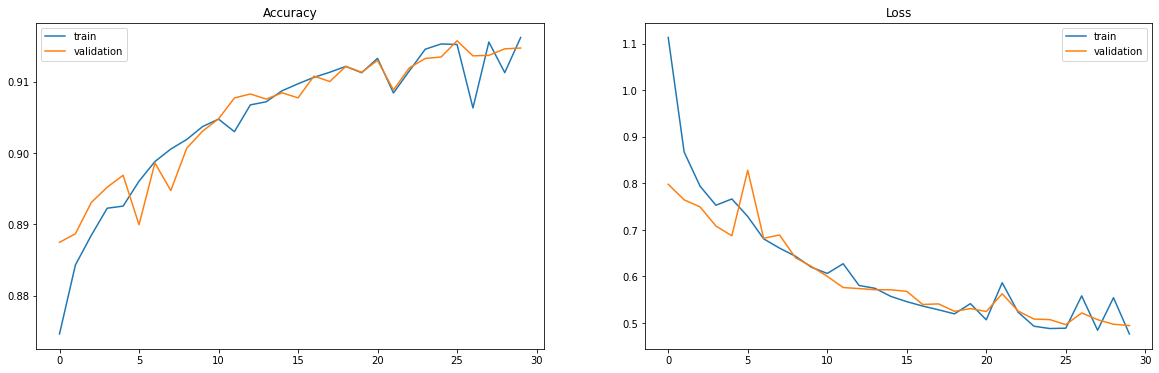

In [ ]:
model_plot_validation(history_simple_rnn_4)

In [ ]:
score = model_simple_rnn_4.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_simple_rnn_4.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.9222516417503357
Training Loss:  0.4186924695968628
Testing Accuracy:  0.9147114157676697
Testing Loss:  0.49446964263916016


Now we don't have overfitting and we may see how the accuracy and loss curves, increases and decreases at the same time.

## Model LSTM (Long Short-Term Memory)

Next we will try same models than before but, this time replacing the SimpleRNN layers by LSTM layers.

In [ ]:
model_lstm_1 = build_basic_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 32, lambda x : LSTM(x))

model_lstm_1.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 32)            848192    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 53, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 53, 13731)         453123    
Total params: 1,309,635
Trainable params: 1,309,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_1 = fit_model(model_lstm_1, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.lstm.1.30_jan_21')

Epoch 1/30
193/193 [==============================] - 140s 552ms/step - loss: 6.4485 - acc: 0.8334 - val_loss: 1.2168 - val_acc: 0.8812

Epoch 00001: val_loss improved from inf to 1.21677, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 105s 543ms/step - loss: 1.1886 - acc: 0.8811 - val_loss: 1.1561 - val_acc: 0.8812

Epoch 00002: val_loss improved from 1.21677 to 1.15615, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 105s 544ms/step - loss: 1.1549 - acc: 0.8811 - val_loss: 1.1499 - val_acc: 0.8812

Epoch 00003: val_loss improved from 1.15615 to 1.14988, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 105s 544ms/step - loss: 1.1464 - acc: 0.8811 - val_loss: 1.1455 - val_acc: 0.8812

Epoch 00004: val_loss improved from 1.14988 to 1.14552, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 105s 544ms/step - loss: 1.1377 - acc: 0.8812 - val_loss: 1.1420 - val_acc: 0.8812

Epoch 00005: val_loss improved from 1.14552 to 1.14198, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 105s 543ms/step - loss: 1.1381 - acc: 0.8807 - val_loss: 1.1389 - val_acc: 0.8812

Epoch 00006: val_loss improved from 1.14198 to 1.13886, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1335 - acc: 0.8809 - val_loss: 1.1361 - val_acc: 0.8812

Epoch 00007: val_loss improved from 1.13886 to 1.13612, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1313 - acc: 0.8809 - val_loss: 1.1343 - val_acc: 0.8812

Epoch 00008: val_loss improved from 1.13612 to 1.13429, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1300 - acc: 0.8809 - val_loss: 1.1329 - val_acc: 0.8812

Epoch 00009: val_loss improved from 1.13429 to 1.13294, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1289 - acc: 0.8809 - val_loss: 1.1317 - val_acc: 0.8812

Epoch 00010: val_loss improved from 1.13294 to 1.13172, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 105s 543ms/step - loss: 1.1289 - acc: 0.8808 - val_loss: 1.1309 - val_acc: 0.8812

Epoch 00011: val_loss improved from 1.13172 to 1.13089, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 12/30
193/193 [==============================] - 105s 541ms/step - loss: 1.1263 - acc: 0.8810 - val_loss: 1.1304 - val_acc: 0.8812

Epoch 00012: val_loss improved from 1.13089 to 1.13039, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 13/30
193/193 [==============================] - 104s 542ms/step - loss: 1.1248 - acc: 0.8812 - val_loss: 1.1297 - val_acc: 0.8812

Epoch 00013: val_loss improved from 1.13039 to 1.12969, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 14/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1271 - acc: 0.8808 - val_loss: 1.1294 - val_acc: 0.8812

Epoch 00014: val_loss improved from 1.12969 to 1.12937, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 15/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1275 - acc: 0.8809 - val_loss: 1.1294 - val_acc: 0.8812

Epoch 00015: val_loss did not improve from 1.12937
Epoch 16/30
193/193 [==============================] - 104s 542ms/step - loss: 1.1234 - acc: 0.8813 - val_loss: 1.1296 - val_acc: 0.8812

Epoch 00016: val_loss did not improve from 1.12937
Epoch 17/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1238 - acc: 0.8812 - val_loss: 1.1286 - val_acc: 0.8812

Epoch 00017: val_loss improved from 1.12937 to 1.12864, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 18/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1271 - acc: 0.8810 - val_loss: 1.1286 - val_acc: 0.8812

Epoch 00018: val_loss improved from 1.12864 to 1.12860, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 19/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1273 - acc: 0.8808 - val_loss: 1.1285 - val_acc: 0.8812

Epoch 00019: val_loss improved from 1.12860 to 1.12851, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 20/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1254 - acc: 0.8811 - val_loss: 1.1283 - val_acc: 0.8812

Epoch 00020: val_loss improved from 1.12851 to 1.12835, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 21/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1268 - acc: 0.8809 - val_loss: 1.1288 - val_acc: 0.8812

Epoch 00021: val_loss did not improve from 1.12835
Epoch 22/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1259 - acc: 0.8810 - val_loss: 1.1281 - val_acc: 0.8812

Epoch 00022: val_loss improved from 1.12835 to 1.12815, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 23/30
193/193 [==============================] - 105s 543ms/step - loss: 1.1256 - acc: 0.8810 - val_loss: 1.1282 - val_acc: 0.8812

Epoch 00023: val_loss did not improve from 1.12815
Epoch 24/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1238 - acc: 0.8812 - val_loss: 1.1283 - val_acc: 0.8812

Epoch 00024: val_loss did not improve from 1.12815
Epoch 25/30
193/193 [==============================] - 105s 543ms/step - loss: 1.1245 - acc: 0.8811 - val_loss: 1.1283 - val_acc: 0.8812

Epoch 00025: val_loss did not improve from 1.12815
Epoch 26/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1260 - acc: 0.8810 - val_loss: 1.1282 - val_acc: 0.8812

Epoch 00026: val_loss did not improve from 1.12815
Epoch 27/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1237 - acc: 0.8812 - val_loss: 1.1281 - val_acc: 0.8812

Epoch 00027: val_loss improved from 1.12815 to 1.12811, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 28/30
193/193 [==============================] - 105s 543ms/step - loss: 1.1237 - acc: 0.8812 - val_loss: 1.1281 - val_acc: 0.8812

Epoch 00028: val_loss improved from 1.12811 to 1.12805, saving model to model.lstm.1.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.1.30_jan_21/assets


Epoch 29/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1259 - acc: 0.8809 - val_loss: 1.1281 - val_acc: 0.8812

Epoch 00029: val_loss did not improve from 1.12805
Epoch 30/30
193/193 [==============================] - 105s 542ms/step - loss: 1.1284 - acc: 0.8807 - val_loss: 1.1281 - val_acc: 0.8812

Epoch 00030: val_loss did not improve from 1.12805
Training completed in time:  0:57:32.977686


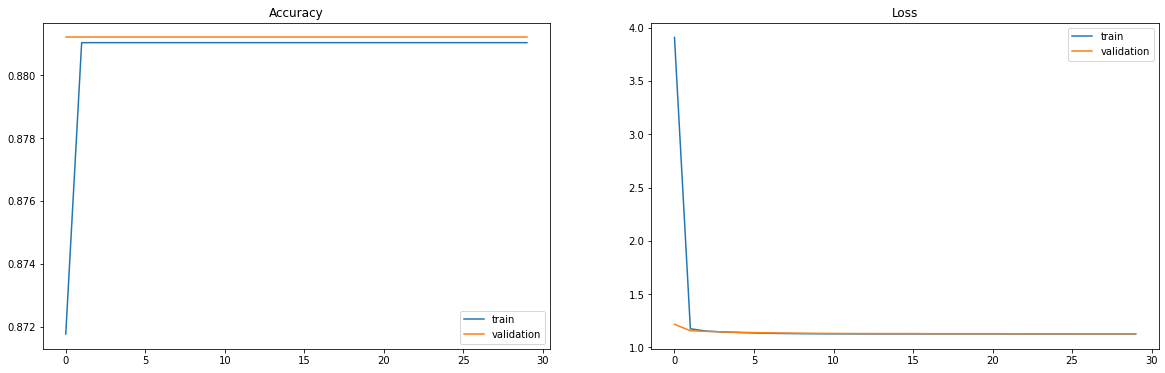

In [ ]:
model_plot_validation(history_lstm_1)

In [ ]:
score = model_lstm_1.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_lstm_1.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.8810375928878784
Training Loss:  1.1249308586120605
Testing Accuracy:  0.8812029957771301
Testing Loss:  1.128055214881897


As before we may see that with one layer and 32 units the model performance does not increase after a few epochs.

So, we try a new model with more units (512).

In [ ]:
model_lstm_2 = build_basic_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, lambda x : LSTM(x))

model_lstm_2.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_lstm_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 512)           13571072  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 53, 512)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 53, 13731)         7044003   
Total params: 22,714,275
Trainable params: 22,714,275
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_2 = fit_model(model_lstm_2, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.lstm.2.30_jan_21')

Epoch 1/30
193/193 [==============================] - 212s 1s/step - loss: 2.2133 - acc: 0.8537 - val_loss: 1.1861 - val_acc: 0.8808

Epoch 00001: val_loss improved from inf to 1.18614, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 205s 1s/step - loss: 1.1692 - acc: 0.8805 - val_loss: 1.1578 - val_acc: 0.8811

Epoch 00002: val_loss improved from 1.18614 to 1.15779, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 205s 1s/step - loss: 1.1089 - acc: 0.8809 - val_loss: 1.1021 - val_acc: 0.8812

Epoch 00003: val_loss improved from 1.15779 to 1.10211, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 206s 1s/step - loss: 1.0675 - acc: 0.8810 - val_loss: 1.0570 - val_acc: 0.8812

Epoch 00004: val_loss improved from 1.10211 to 1.05702, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 206s 1s/step - loss: 1.0278 - acc: 0.8808 - val_loss: 1.0162 - val_acc: 0.8812

Epoch 00005: val_loss improved from 1.05702 to 1.01616, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 206s 1s/step - loss: 0.9785 - acc: 0.8811 - val_loss: 0.9672 - val_acc: 0.8812

Epoch 00006: val_loss improved from 1.01616 to 0.96717, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 205s 1s/step - loss: 0.9372 - acc: 0.8812 - val_loss: 0.9332 - val_acc: 0.8812

Epoch 00007: val_loss improved from 0.96717 to 0.93324, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 206s 1s/step - loss: 0.8992 - acc: 0.8809 - val_loss: 0.9147 - val_acc: 0.8812

Epoch 00008: val_loss improved from 0.93324 to 0.91472, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 206s 1s/step - loss: 0.8653 - acc: 0.8809 - val_loss: 0.8791 - val_acc: 0.8812

Epoch 00009: val_loss improved from 0.91472 to 0.87913, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 206s 1s/step - loss: 0.8365 - acc: 0.8811 - val_loss: 0.8626 - val_acc: 0.8812

Epoch 00010: val_loss improved from 0.87913 to 0.86264, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 206s 1s/step - loss: 0.8129 - acc: 0.8810 - val_loss: 0.8470 - val_acc: 0.8812

Epoch 00011: val_loss improved from 0.86264 to 0.84701, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 12/30
193/193 [==============================] - 206s 1s/step - loss: 0.7949 - acc: 0.8809 - val_loss: 0.8350 - val_acc: 0.8811

Epoch 00012: val_loss improved from 0.84701 to 0.83497, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 13/30
193/193 [==============================] - 206s 1s/step - loss: 0.7766 - acc: 0.8810 - val_loss: 0.8296 - val_acc: 0.8811

Epoch 00013: val_loss improved from 0.83497 to 0.82959, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 14/30
193/193 [==============================] - 206s 1s/step - loss: 0.7630 - acc: 0.8808 - val_loss: 0.8248 - val_acc: 0.8811

Epoch 00014: val_loss improved from 0.82959 to 0.82476, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 15/30
193/193 [==============================] - 206s 1s/step - loss: 0.7494 - acc: 0.8810 - val_loss: 0.8155 - val_acc: 0.8811

Epoch 00015: val_loss improved from 0.82476 to 0.81546, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 16/30
193/193 [==============================] - 206s 1s/step - loss: 0.7360 - acc: 0.8812 - val_loss: 0.8119 - val_acc: 0.8810

Epoch 00016: val_loss improved from 0.81546 to 0.81194, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 17/30
193/193 [==============================] - 206s 1s/step - loss: 0.7270 - acc: 0.8810 - val_loss: 0.8116 - val_acc: 0.8811

Epoch 00017: val_loss improved from 0.81194 to 0.81164, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 18/30
193/193 [==============================] - 206s 1s/step - loss: 0.7168 - acc: 0.8811 - val_loss: 0.8064 - val_acc: 0.8809

Epoch 00018: val_loss improved from 0.81164 to 0.80642, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 19/30
193/193 [==============================] - 206s 1s/step - loss: 0.7087 - acc: 0.8809 - val_loss: 0.8054 - val_acc: 0.8808

Epoch 00019: val_loss improved from 0.80642 to 0.80543, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 20/30
193/193 [==============================] - 205s 1s/step - loss: 0.7019 - acc: 0.8808 - val_loss: 0.8047 - val_acc: 0.8807

Epoch 00020: val_loss improved from 0.80543 to 0.80472, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 21/30
193/193 [==============================] - 205s 1s/step - loss: 0.6927 - acc: 0.8812 - val_loss: 0.8038 - val_acc: 0.8806

Epoch 00021: val_loss improved from 0.80472 to 0.80380, saving model to model.lstm.2.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.2.30_jan_21/assets


Epoch 22/30
193/193 [==============================] - 205s 1s/step - loss: 0.6868 - acc: 0.8810 - val_loss: 0.8050 - val_acc: 0.8802

Epoch 00022: val_loss did not improve from 0.80380
Epoch 23/30
193/193 [==============================] - 205s 1s/step - loss: 0.6810 - acc: 0.8810 - val_loss: 0.8055 - val_acc: 0.8802

Epoch 00023: val_loss did not improve from 0.80380
Epoch 24/30
193/193 [==============================] - 205s 1s/step - loss: 0.6753 - acc: 0.8811 - val_loss: 0.8047 - val_acc: 0.8803

Epoch 00024: val_loss did not improve from 0.80380
Epoch 25/30
193/193 [==============================] - 205s 1s/step - loss: 0.6713 - acc: 0.8809 - val_loss: 0.8058 - val_acc: 0.8800

Epoch 00025: val_loss did not improve from 0.80380
Epoch 26/30
193/193 [==============================] - 205s 1s/step - loss: 0.6667 - acc: 0.8808 - val_loss: 0.8071 - val_acc: 0.8799

Epoch 00026: val_loss did not improve from 0.80380
Epoch 27/30
193/193 [==============================] - 205s 1s/step - 

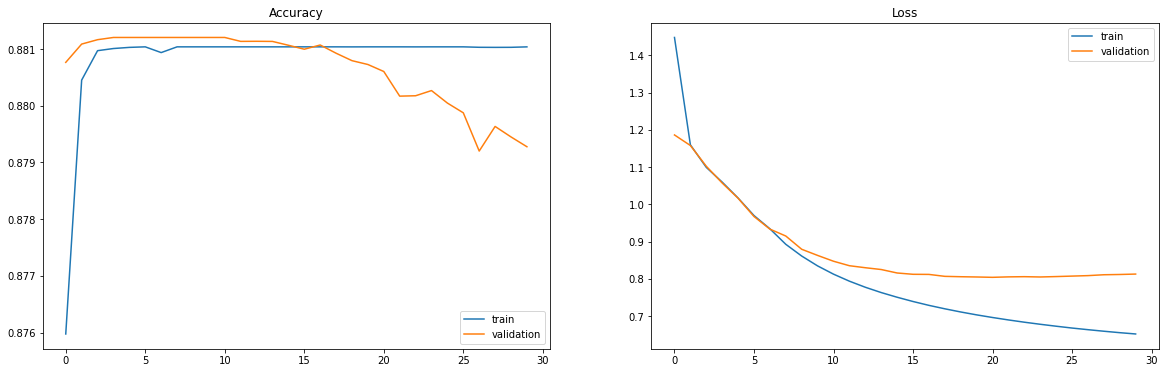

In [ ]:
model_plot_validation(history_lstm_2)

In [ ]:
score = model_lstm_2.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_lstm_2.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.8809725046157837
Training Loss:  0.6485681533813477
Testing Accuracy:  0.8792768716812134
Testing Loss:  0.8125348091125488


Taking a look at the training curve it seems that it is still not improving with new epochs. Also, we have overfiting.

The new model we will try next will incude a new LSTM layer:

In [ ]:
model_lstm_3 = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, lambda x : LSTM(x), lambda x: LSTM(x, return_sequences=True))

model_lstm_3.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_lstm_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 512)           13571072  
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 53, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 53, 512)           2099200   
_________________________________________________________________
dense_2 (Dense)              (None, 53, 13731)         7044003   
Total params: 24,813,475
Trainable params: 24,813,475
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_3 = fit_model(model_lstm_3, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.lstm.3.30_jan_21')

Epoch 1/30
193/193 [==============================] - 253s 1s/step - loss: 1.5980 - acc: 0.8572 - val_loss: 0.7705 - val_acc: 0.8876

Epoch 00001: val_loss improved from inf to 0.77053, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 243s 1s/step - loss: 0.7544 - acc: 0.8889 - val_loss: 0.7233 - val_acc: 0.8916

Epoch 00002: val_loss improved from 0.77053 to 0.72327, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 244s 1s/step - loss: 0.7038 - acc: 0.8929 - val_loss: 0.6831 - val_acc: 0.8963

Epoch 00003: val_loss improved from 0.72327 to 0.68309, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 242s 1s/step - loss: 0.6536 - acc: 0.8982 - val_loss: 0.6305 - val_acc: 0.9016

Epoch 00004: val_loss improved from 0.68309 to 0.63053, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 243s 1s/step - loss: 0.6042 - acc: 0.9035 - val_loss: 0.5920 - val_acc: 0.9057

Epoch 00005: val_loss improved from 0.63053 to 0.59202, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 244s 1s/step - loss: 0.5577 - acc: 0.9082 - val_loss: 0.5542 - val_acc: 0.9092

Epoch 00006: val_loss improved from 0.59202 to 0.55423, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 243s 1s/step - loss: 0.5141 - acc: 0.9125 - val_loss: 0.5306 - val_acc: 0.9126

Epoch 00007: val_loss improved from 0.55423 to 0.53055, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 244s 1s/step - loss: 0.4719 - acc: 0.9169 - val_loss: 0.4989 - val_acc: 0.9148

Epoch 00008: val_loss improved from 0.53055 to 0.49893, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 243s 1s/step - loss: 0.4335 - acc: 0.9210 - val_loss: 0.4744 - val_acc: 0.9180

Epoch 00009: val_loss improved from 0.49893 to 0.47435, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 245s 1s/step - loss: 0.4021 - acc: 0.9243 - val_loss: 0.4462 - val_acc: 0.9205

Epoch 00010: val_loss improved from 0.47435 to 0.44622, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 243s 1s/step - loss: 0.3708 - acc: 0.9280 - val_loss: 0.4318 - val_acc: 0.9223

Epoch 00011: val_loss improved from 0.44622 to 0.43177, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 12/30
193/193 [==============================] - 243s 1s/step - loss: 0.3447 - acc: 0.9311 - val_loss: 0.4182 - val_acc: 0.9239

Epoch 00012: val_loss improved from 0.43177 to 0.41821, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 13/30
193/193 [==============================] - 245s 1s/step - loss: 0.3207 - acc: 0.9345 - val_loss: 0.4132 - val_acc: 0.9236

Epoch 00013: val_loss improved from 0.41821 to 0.41322, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 14/30
193/193 [==============================] - 242s 1s/step - loss: 0.3004 - acc: 0.9373 - val_loss: 0.3996 - val_acc: 0.9267

Epoch 00014: val_loss improved from 0.41322 to 0.39956, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 15/30
193/193 [==============================] - 243s 1s/step - loss: 0.2803 - acc: 0.9403 - val_loss: 0.4052 - val_acc: 0.9237

Epoch 00015: val_loss did not improve from 0.39956
Epoch 16/30
193/193 [==============================] - 244s 1s/step - loss: 0.2628 - acc: 0.9429 - val_loss: 0.3913 - val_acc: 0.9275

Epoch 00016: val_loss improved from 0.39956 to 0.39127, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 17/30
193/193 [==============================] - 244s 1s/step - loss: 0.2466 - acc: 0.9457 - val_loss: 0.3932 - val_acc: 0.9278

Epoch 00017: val_loss did not improve from 0.39127
Epoch 18/30
193/193 [==============================] - 242s 1s/step - loss: 0.2307 - acc: 0.9484 - val_loss: 0.3862 - val_acc: 0.9288

Epoch 00018: val_loss improved from 0.39127 to 0.38617, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 19/30
193/193 [==============================] - 244s 1s/step - loss: 0.2153 - acc: 0.9513 - val_loss: 0.3859 - val_acc: 0.9293

Epoch 00019: val_loss improved from 0.38617 to 0.38590, saving model to model.lstm.3.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.3.30_jan_21/assets


Epoch 20/30
193/193 [==============================] - 244s 1s/step - loss: 0.2030 - acc: 0.9535 - val_loss: 0.3870 - val_acc: 0.9290

Epoch 00020: val_loss did not improve from 0.38590
Epoch 21/30
193/193 [==============================] - 243s 1s/step - loss: 0.1905 - acc: 0.9560 - val_loss: 0.3908 - val_acc: 0.9300

Epoch 00021: val_loss did not improve from 0.38590
Epoch 22/30
193/193 [==============================] - 243s 1s/step - loss: 0.1779 - acc: 0.9585 - val_loss: 0.3916 - val_acc: 0.9299

Epoch 00022: val_loss did not improve from 0.38590
Epoch 23/30
193/193 [==============================] - 243s 1s/step - loss: 0.1650 - acc: 0.9612 - val_loss: 0.3927 - val_acc: 0.9299

Epoch 00023: val_loss did not improve from 0.38590
Epoch 24/30
193/193 [==============================] - 244s 1s/step - loss: 0.1550 - acc: 0.9634 - val_loss: 0.3962 - val_acc: 0.9300

Epoch 00024: val_loss did not improve from 0.38590
Epoch 25/30
193/193 [==============================] - 242s 1s/step - 

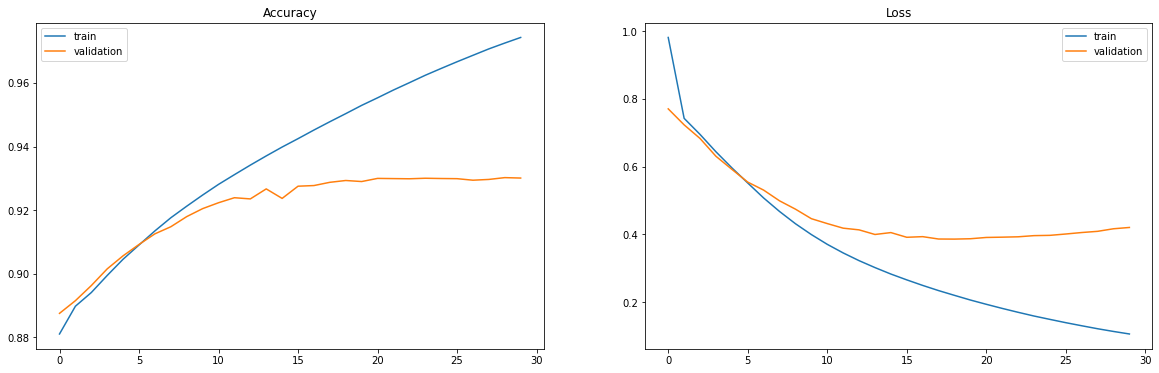

In [ ]:
model_plot_validation(history_lstm_3)

In [ ]:
score = model_lstm_3.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_lstm_3.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.9759368300437927
Training Loss:  0.09779193252325058
Testing Accuracy:  0.9301077723503113
Testing Loss:  0.4202823042869568


As before, we have overfiting. Next model will include dropout to see if it disapears.

In [ ]:
model_lstm_4 = build_model_with_dropout(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, 
                                        lambda x : LSTM(x), 
                                        lambda x: LSTM(x, return_sequences=True),
                                        0.5)

model_lstm_4.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_lstm_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 512)           13571072  
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 53, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 53, 512)           2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 512)           0         
_________________________________________________________________
dense (Dense)                (None, 53, 13731)         7

In [ ]:
history_lstm_4 = fit_model(model_lstm_4, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.lstm.4.30_jan_21')

Epoch 1/30
193/193 [==============================] - 167s 683ms/step - loss: 1.6024 - acc: 0.8567 - val_loss: 0.7585 - val_acc: 0.8878

Epoch 00001: val_loss improved from inf to 0.75851, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 133s 692ms/step - loss: 0.7922 - acc: 0.8866 - val_loss: 0.7270 - val_acc: 0.8907

Epoch 00002: val_loss improved from 0.75851 to 0.72701, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 133s 690ms/step - loss: 0.7236 - acc: 0.8918 - val_loss: 0.6885 - val_acc: 0.8951

Epoch 00003: val_loss improved from 0.72701 to 0.68851, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 133s 691ms/step - loss: 0.6847 - acc: 0.8957 - val_loss: 0.6523 - val_acc: 0.8990

Epoch 00004: val_loss improved from 0.68851 to 0.65230, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 133s 691ms/step - loss: 0.6480 - acc: 0.8996 - val_loss: 0.6196 - val_acc: 0.9032

Epoch 00005: val_loss improved from 0.65230 to 0.61961, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 133s 691ms/step - loss: 0.6120 - acc: 0.9035 - val_loss: 0.5843 - val_acc: 0.9068

Epoch 00006: val_loss improved from 0.61961 to 0.58429, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 134s 692ms/step - loss: 0.5825 - acc: 0.9063 - val_loss: 0.5595 - val_acc: 0.9093

Epoch 00007: val_loss improved from 0.58429 to 0.55946, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 133s 691ms/step - loss: 0.5539 - acc: 0.9092 - val_loss: 0.5361 - val_acc: 0.9122

Epoch 00008: val_loss improved from 0.55946 to 0.53611, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 134s 692ms/step - loss: 0.5320 - acc: 0.9113 - val_loss: 0.5165 - val_acc: 0.9137

Epoch 00009: val_loss improved from 0.53611 to 0.51653, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 134s 693ms/step - loss: 0.5089 - acc: 0.9137 - val_loss: 0.5005 - val_acc: 0.9155

Epoch 00010: val_loss improved from 0.51653 to 0.50051, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 133s 692ms/step - loss: 0.4919 - acc: 0.9154 - val_loss: 0.4837 - val_acc: 0.9175

Epoch 00011: val_loss improved from 0.50051 to 0.48369, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 12/30
193/193 [==============================] - 134s 692ms/step - loss: 0.4738 - acc: 0.9171 - val_loss: 0.4706 - val_acc: 0.9194

Epoch 00012: val_loss improved from 0.48369 to 0.47063, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 13/30
193/193 [==============================] - 134s 694ms/step - loss: 0.4593 - acc: 0.9187 - val_loss: 0.4584 - val_acc: 0.9207

Epoch 00013: val_loss improved from 0.47063 to 0.45837, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 14/30
193/193 [==============================] - 134s 695ms/step - loss: 0.4447 - acc: 0.9203 - val_loss: 0.4456 - val_acc: 0.9218

Epoch 00014: val_loss improved from 0.45837 to 0.44563, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 15/30
193/193 [==============================] - 134s 693ms/step - loss: 0.4344 - acc: 0.9214 - val_loss: 0.4369 - val_acc: 0.9227

Epoch 00015: val_loss improved from 0.44563 to 0.43686, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 16/30
193/193 [==============================] - 133s 692ms/step - loss: 0.4258 - acc: 0.9226 - val_loss: 0.4288 - val_acc: 0.9242

Epoch 00016: val_loss improved from 0.43686 to 0.42879, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 17/30
193/193 [==============================] - 134s 693ms/step - loss: 0.4139 - acc: 0.9239 - val_loss: 0.4240 - val_acc: 0.9248

Epoch 00017: val_loss improved from 0.42879 to 0.42400, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 18/30
193/193 [==============================] - 134s 694ms/step - loss: 0.4046 - acc: 0.9250 - val_loss: 0.4171 - val_acc: 0.9252

Epoch 00018: val_loss improved from 0.42400 to 0.41711, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 19/30
193/193 [==============================] - 134s 695ms/step - loss: 0.3958 - acc: 0.9260 - val_loss: 0.4149 - val_acc: 0.9255

Epoch 00019: val_loss improved from 0.41711 to 0.41494, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 20/30
193/193 [==============================] - 134s 696ms/step - loss: 0.3900 - acc: 0.9267 - val_loss: 0.4072 - val_acc: 0.9267

Epoch 00020: val_loss improved from 0.41494 to 0.40719, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 21/30
193/193 [==============================] - 134s 694ms/step - loss: 0.3805 - acc: 0.9279 - val_loss: 0.4024 - val_acc: 0.9277

Epoch 00021: val_loss improved from 0.40719 to 0.40237, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 22/30
193/193 [==============================] - 134s 696ms/step - loss: 0.3735 - acc: 0.9289 - val_loss: 0.4028 - val_acc: 0.9284

Epoch 00022: val_loss did not improve from 0.40237
Epoch 23/30
193/193 [==============================] - 134s 693ms/step - loss: 0.3676 - acc: 0.9298 - val_loss: 0.3979 - val_acc: 0.9286

Epoch 00023: val_loss improved from 0.40237 to 0.39793, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 24/30
193/193 [==============================] - 134s 697ms/step - loss: 0.3607 - acc: 0.9309 - val_loss: 0.4023 - val_acc: 0.9288

Epoch 00024: val_loss did not improve from 0.39793
Epoch 25/30
193/193 [==============================] - 134s 694ms/step - loss: 0.3570 - acc: 0.9312 - val_loss: 0.3922 - val_acc: 0.9294

Epoch 00025: val_loss improved from 0.39793 to 0.39222, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 26/30
193/193 [==============================] - 134s 696ms/step - loss: 0.3490 - acc: 0.9323 - val_loss: 0.3907 - val_acc: 0.9294

Epoch 00026: val_loss improved from 0.39222 to 0.39069, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 27/30
193/193 [==============================] - 135s 697ms/step - loss: 0.3442 - acc: 0.9333 - val_loss: 0.3882 - val_acc: 0.9300

Epoch 00027: val_loss improved from 0.39069 to 0.38817, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 28/30
193/193 [==============================] - 134s 697ms/step - loss: 0.3414 - acc: 0.9336 - val_loss: 0.3873 - val_acc: 0.9303

Epoch 00028: val_loss improved from 0.38817 to 0.38733, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 29/30
193/193 [==============================] - 134s 696ms/step - loss: 0.3363 - acc: 0.9343 - val_loss: 0.3845 - val_acc: 0.9307

Epoch 00029: val_loss improved from 0.38733 to 0.38453, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Epoch 30/30
193/193 [==============================] - 135s 698ms/step - loss: 0.3332 - acc: 0.9350 - val_loss: 0.3836 - val_acc: 0.9308

Epoch 00030: val_loss improved from 0.38453 to 0.38365, saving model to model.lstm.4.30_jan_21


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.lstm.4.30_jan_21/assets


Training completed in time:  1:13:17.531693


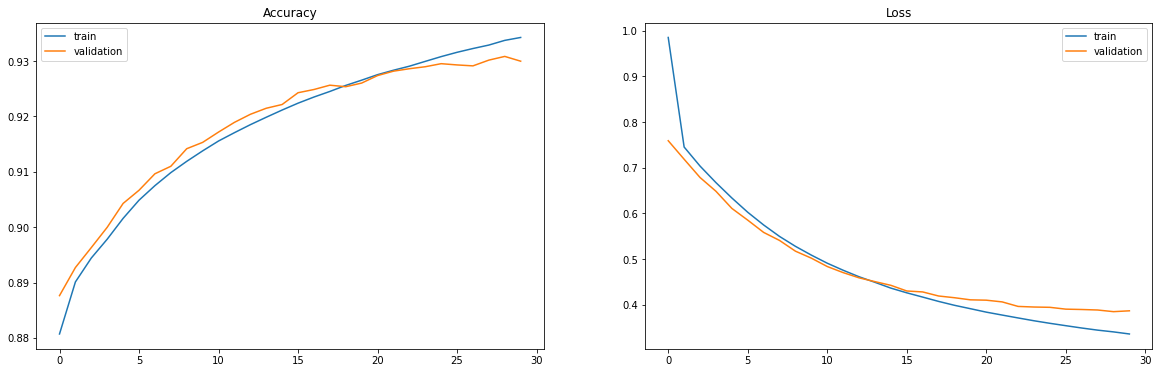

In [ ]:
model_plot_validation(history_lstm_4)

In [ ]:
score = model_lstm_4.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_lstm_4.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.9474948644638062
Training Loss:  0.2570018470287323
Testing Accuracy:  0.9299827218055725
Testing Loss:  0.38645172119140625


This last model has improved the rest. As the accuracy has increased and the loss has decreased. It seems there is no overfiting.

## Model GRU

Next let's build the same models but this time using a GRU layer. It should be cheaper to run than LSTM.

In [ ]:
model_gru_1 = build_basic_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 32, lambda x : GRU(x))

model_gru_1.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_gru_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 53, 32)            848192    
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 53, 32)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 53, 13731)         453123    
Total params: 1,307,651
Trainable params: 1,307,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_gru_1 = fit_model(model_gru_1, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.GRU.1.30_jan_21')

Epoch 1/30
193/193 [==============================] - 109s 543ms/step - loss: 6.2034 - acc: 0.8291 - val_loss: 1.1747 - val_acc: 0.8812

Epoch 00001: val_loss improved from inf to 1.17465, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 103s 535ms/step - loss: 1.1612 - acc: 0.8811 - val_loss: 1.1393 - val_acc: 0.8812

Epoch 00002: val_loss improved from 1.17465 to 1.13928, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1352 - acc: 0.8813 - val_loss: 1.1321 - val_acc: 0.8812

Epoch 00003: val_loss improved from 1.13928 to 1.13212, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1269 - acc: 0.8812 - val_loss: 1.1281 - val_acc: 0.8812

Epoch 00004: val_loss improved from 1.13212 to 1.12815, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 103s 535ms/step - loss: 1.1259 - acc: 0.8809 - val_loss: 1.1262 - val_acc: 0.8812

Epoch 00005: val_loss improved from 1.12815 to 1.12621, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1234 - acc: 0.8810 - val_loss: 1.1255 - val_acc: 0.8812

Epoch 00006: val_loss improved from 1.12621 to 1.12547, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1235 - acc: 0.8810 - val_loss: 1.1250 - val_acc: 0.8812

Epoch 00007: val_loss improved from 1.12547 to 1.12498, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1228 - acc: 0.8811 - val_loss: 1.1250 - val_acc: 0.8812

Epoch 00008: val_loss improved from 1.12498 to 1.12496, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1204 - acc: 0.8813 - val_loss: 1.1247 - val_acc: 0.8812

Epoch 00009: val_loss improved from 1.12496 to 1.12471, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1225 - acc: 0.8810 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00010: val_loss improved from 1.12471 to 1.12437, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1213 - acc: 0.8811 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00011: val_loss did not improve from 1.12437
Epoch 12/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1213 - acc: 0.8811 - val_loss: 1.1247 - val_acc: 0.8812

Epoch 00012: val_loss did not improve from 1.12437
Epoch 13/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1228 - acc: 0.8810 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00013: val_loss did not improve from 1.12437
Epoch 14/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1249 - acc: 0.8807 - val_loss: 1.1245 - val_acc: 0.8812

Epoch 00014: val_loss did not improve from 1.12437
Epoch 15/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1210 - acc: 0.8812 - val_loss: 1.1243 - val_acc: 0.8812

Epoch 00015: val_loss improved from 1.12437 to 1.12434, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 16/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1209 - acc: 0.8812 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00016: val_loss did not improve from 1.12434
Epoch 17/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1234 - acc: 0.8809 - val_loss: 1.1246 - val_acc: 0.8812

Epoch 00017: val_loss did not improve from 1.12434
Epoch 18/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1232 - acc: 0.8809 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00018: val_loss did not improve from 1.12434
Epoch 19/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1217 - acc: 0.8811 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00019: val_loss did not improve from 1.12434
Epoch 20/30
193/193 [==============================] - 103s 535ms/step - loss: 1.1234 - acc: 0.8809 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00020: val_loss did not improve from 1.12434
Epoch 21/30
193/193 [==============================] - 

INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 23/30
193/193 [==============================] - 103s 535ms/step - loss: 1.1210 - acc: 0.8812 - val_loss: 1.1245 - val_acc: 0.8812

Epoch 00023: val_loss did not improve from 1.12433
Epoch 24/30
193/193 [==============================] - 103s 535ms/step - loss: 1.1233 - acc: 0.8809 - val_loss: 1.1248 - val_acc: 0.8812

Epoch 00024: val_loss did not improve from 1.12433
Epoch 25/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1225 - acc: 0.8811 - val_loss: 1.1248 - val_acc: 0.8812

Epoch 00025: val_loss did not improve from 1.12433
Epoch 26/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1221 - acc: 0.8811 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00026: val_loss did not improve from 1.12433
Epoch 27/30
193/193 [==============================] - 103s 535ms/step - loss: 1.1218 - acc: 0.8811 - val_loss: 1.1243 - val_acc: 0.8812

Epoch 00027: val_loss improved from 1.12433 to 1.12432, saving model to model.GRU.1.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.1.30_jan_21/assets


Epoch 28/30
193/193 [==============================] - 103s 536ms/step - loss: 1.1233 - acc: 0.8810 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00028: val_loss did not improve from 1.12432
Epoch 29/30
193/193 [==============================] - 103s 535ms/step - loss: 1.1224 - acc: 0.8811 - val_loss: 1.1244 - val_acc: 0.8812

Epoch 00029: val_loss did not improve from 1.12432
Epoch 30/30
193/193 [==============================] - 103s 535ms/step - loss: 1.1228 - acc: 0.8810 - val_loss: 1.1243 - val_acc: 0.8812

Epoch 00030: val_loss did not improve from 1.12432
Training completed in time:  0:54:20.865396


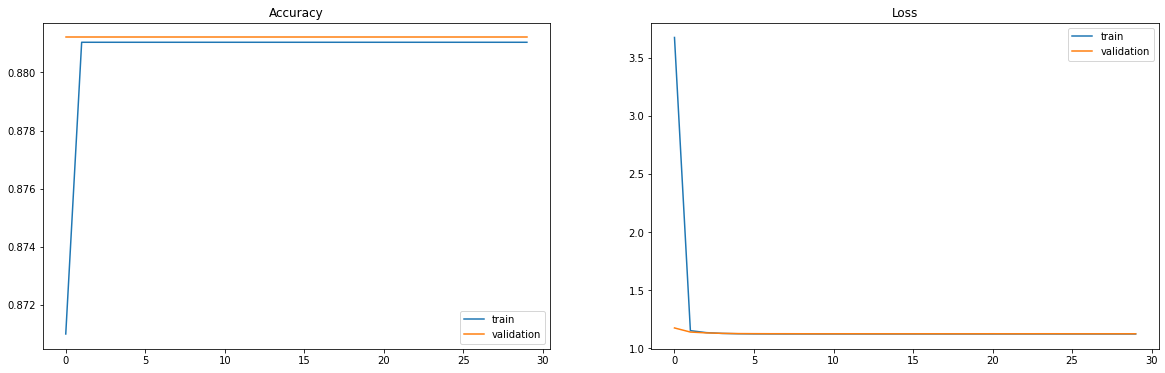

In [ ]:
model_plot_validation(history_gru_1)

In [ ]:
score = model_gru_1.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_gru_1.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.8810375928878784
Training Loss:  1.1217759847640991
Testing Accuracy:  0.8812029957771301
Testing Loss:  1.1243484020233154


Accuracy and loss improve slightly after each epoch. So, let's try same model with more units.
 

In [ ]:
model_gru_2 = build_basic_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, lambda x : GRU(x))

model_gru_2.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_gru_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 512)           13571072  
_________________________________________________________________
gru (GRU)                    (None, 512)               1575936   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 53, 512)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 53, 13731)         7044003   
Total params: 22,191,011
Trainable params: 22,191,011
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_gru_2 = fit_model(model_gru_2, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.GRU.2.30_jan_21')

Epoch 1/30
193/193 [==============================] - 238s 1s/step - loss: 2.1103 - acc: 0.8542 - val_loss: 1.1806 - val_acc: 0.8811

Epoch 00001: val_loss improved from inf to 1.18059, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 203s 1s/step - loss: 1.1452 - acc: 0.8810 - val_loss: 1.1181 - val_acc: 0.8812

Epoch 00002: val_loss improved from 1.18059 to 1.11810, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 203s 1s/step - loss: 1.0928 - acc: 0.8810 - val_loss: 1.0898 - val_acc: 0.8812

Epoch 00003: val_loss improved from 1.11810 to 1.08975, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 203s 1s/step - loss: 1.0494 - acc: 0.8811 - val_loss: 1.0351 - val_acc: 0.8812

Epoch 00004: val_loss improved from 1.08975 to 1.03514, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 204s 1s/step - loss: 1.0049 - acc: 0.8811 - val_loss: 1.0121 - val_acc: 0.8811

Epoch 00005: val_loss improved from 1.03514 to 1.01208, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 204s 1s/step - loss: 0.9690 - acc: 0.8808 - val_loss: 0.9732 - val_acc: 0.8811

Epoch 00006: val_loss improved from 1.01208 to 0.97317, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 204s 1s/step - loss: 0.9299 - acc: 0.8814 - val_loss: 0.9408 - val_acc: 0.8811

Epoch 00007: val_loss improved from 0.97317 to 0.94081, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 204s 1s/step - loss: 0.9022 - acc: 0.8811 - val_loss: 0.9150 - val_acc: 0.8811

Epoch 00008: val_loss improved from 0.94081 to 0.91501, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 204s 1s/step - loss: 0.8752 - acc: 0.8810 - val_loss: 0.9035 - val_acc: 0.8811

Epoch 00009: val_loss improved from 0.91501 to 0.90346, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 205s 1s/step - loss: 0.8529 - acc: 0.8808 - val_loss: 0.8818 - val_acc: 0.8811

Epoch 00010: val_loss improved from 0.90346 to 0.88183, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 205s 1s/step - loss: 0.8284 - acc: 0.8813 - val_loss: 0.8716 - val_acc: 0.8811

Epoch 00011: val_loss improved from 0.88183 to 0.87164, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 12/30
193/193 [==============================] - 205s 1s/step - loss: 0.8128 - acc: 0.8808 - val_loss: 0.8560 - val_acc: 0.8811

Epoch 00012: val_loss improved from 0.87164 to 0.85597, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 13/30
193/193 [==============================] - 205s 1s/step - loss: 0.7921 - acc: 0.8812 - val_loss: 0.8520 - val_acc: 0.8811

Epoch 00013: val_loss improved from 0.85597 to 0.85196, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 14/30
193/193 [==============================] - 205s 1s/step - loss: 0.7772 - acc: 0.8811 - val_loss: 0.8380 - val_acc: 0.8811

Epoch 00014: val_loss improved from 0.85196 to 0.83799, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 15/30
193/193 [==============================] - 205s 1s/step - loss: 0.7641 - acc: 0.8809 - val_loss: 0.8337 - val_acc: 0.8811

Epoch 00015: val_loss improved from 0.83799 to 0.83375, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 16/30
193/193 [==============================] - 204s 1s/step - loss: 0.7499 - acc: 0.8811 - val_loss: 0.8278 - val_acc: 0.8811

Epoch 00016: val_loss improved from 0.83375 to 0.82784, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 17/30
193/193 [==============================] - 204s 1s/step - loss: 0.7388 - acc: 0.8809 - val_loss: 0.8260 - val_acc: 0.8811

Epoch 00017: val_loss improved from 0.82784 to 0.82600, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 18/30
193/193 [==============================] - 205s 1s/step - loss: 0.7257 - acc: 0.8813 - val_loss: 0.8204 - val_acc: 0.8811

Epoch 00018: val_loss improved from 0.82600 to 0.82044, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 19/30
193/193 [==============================] - 204s 1s/step - loss: 0.7183 - acc: 0.8809 - val_loss: 0.8235 - val_acc: 0.8811

Epoch 00019: val_loss did not improve from 0.82044
Epoch 20/30
193/193 [==============================] - 204s 1s/step - loss: 0.7075 - acc: 0.8812 - val_loss: 0.8223 - val_acc: 0.8810

Epoch 00020: val_loss did not improve from 0.82044
Epoch 21/30
193/193 [==============================] - 204s 1s/step - loss: 0.6999 - acc: 0.8811 - val_loss: 0.8154 - val_acc: 0.8809

Epoch 00021: val_loss improved from 0.82044 to 0.81541, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 22/30
193/193 [==============================] - 204s 1s/step - loss: 0.6928 - acc: 0.8809 - val_loss: 0.8154 - val_acc: 0.8807

Epoch 00022: val_loss improved from 0.81541 to 0.81539, saving model to model.GRU.2.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.2.30_jan_21/assets


Epoch 23/30
193/193 [==============================] - 205s 1s/step - loss: 0.6874 - acc: 0.8807 - val_loss: 0.8159 - val_acc: 0.8807

Epoch 00023: val_loss did not improve from 0.81539
Epoch 24/30
193/193 [==============================] - 204s 1s/step - loss: 0.6767 - acc: 0.8814 - val_loss: 0.8170 - val_acc: 0.8807

Epoch 00024: val_loss did not improve from 0.81539
Epoch 25/30
193/193 [==============================] - 205s 1s/step - loss: 0.6725 - acc: 0.8810 - val_loss: 0.8180 - val_acc: 0.8805

Epoch 00025: val_loss did not improve from 0.81539
Epoch 26/30
193/193 [==============================] - 205s 1s/step - loss: 0.6666 - acc: 0.8811 - val_loss: 0.8186 - val_acc: 0.8804

Epoch 00026: val_loss did not improve from 0.81539
Epoch 27/30
193/193 [==============================] - 204s 1s/step - loss: 0.6626 - acc: 0.8809 - val_loss: 0.8203 - val_acc: 0.8804

Epoch 00027: val_loss did not improve from 0.81539
Epoch 28/30
193/193 [==============================] - 204s 1s/step - 

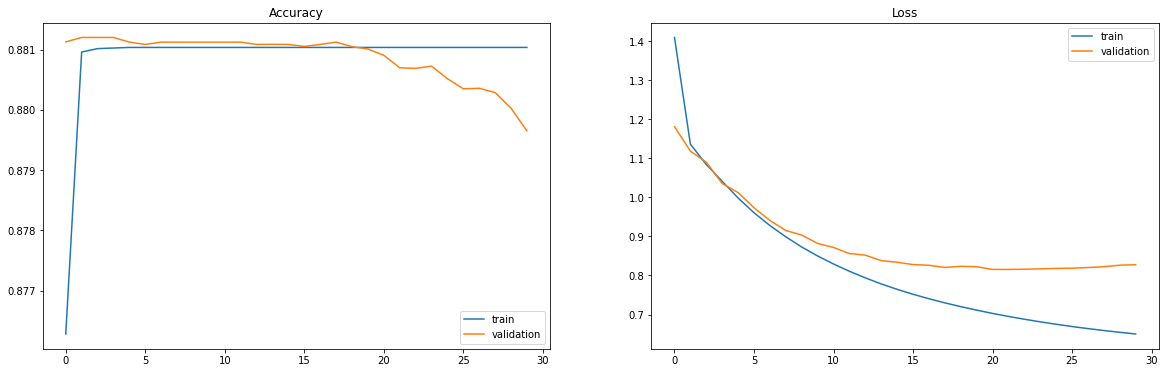

In [ ]:
model_plot_validation(history_gru_2)

In [ ]:
score = model_gru_2.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_gru_2.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.8810216188430786
Training Loss:  0.6454361081123352
Testing Accuracy:  0.8796521425247192
Testing Loss:  0.8273447751998901


With this new model we have introduced overfitting so, we will add a dropout layer.


In [ ]:
model_gru_3 = build_basic_model_with_drop_out(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, lambda x : GRU(x), 0.5)

model_gru_3.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_gru_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 512)           13571072  
_________________________________________________________________
gru_1 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 53, 512)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 53, 13731)         7044003   
Total params: 22,191,011
Trainable params: 22,191,011
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_gru_3 = fit_model(model_gru_3, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.GRU.3.30_jan_21')

Epoch 1/30
193/193 [==============================] - 209s 1s/step - loss: 2.1332 - acc: 0.8540 - val_loss: 1.1704 - val_acc: 0.8811

Epoch 00001: val_loss improved from inf to 1.17044, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 202s 1s/step - loss: 1.1699 - acc: 0.8811 - val_loss: 1.1297 - val_acc: 0.8812

Epoch 00002: val_loss improved from 1.17044 to 1.12972, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 202s 1s/step - loss: 1.1257 - acc: 0.8811 - val_loss: 1.0902 - val_acc: 0.8812

Epoch 00003: val_loss improved from 1.12972 to 1.09020, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 203s 1s/step - loss: 1.1133 - acc: 0.8802 - val_loss: 1.0622 - val_acc: 0.8812

Epoch 00004: val_loss improved from 1.09020 to 1.06220, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 203s 1s/step - loss: 1.0763 - acc: 0.8810 - val_loss: 1.0382 - val_acc: 0.8812

Epoch 00005: val_loss improved from 1.06220 to 1.03819, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 204s 1s/step - loss: 1.0496 - acc: 0.8808 - val_loss: 1.0157 - val_acc: 0.8812

Epoch 00006: val_loss improved from 1.03819 to 1.01569, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 203s 1s/step - loss: 1.0199 - acc: 0.8809 - val_loss: 0.9813 - val_acc: 0.8812

Epoch 00007: val_loss improved from 1.01569 to 0.98129, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 203s 1s/step - loss: 0.9912 - acc: 0.8812 - val_loss: 0.9726 - val_acc: 0.8812

Epoch 00008: val_loss improved from 0.98129 to 0.97258, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 203s 1s/step - loss: 0.9731 - acc: 0.8810 - val_loss: 0.9319 - val_acc: 0.8812

Epoch 00009: val_loss improved from 0.97258 to 0.93191, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 203s 1s/step - loss: 0.9535 - acc: 0.8814 - val_loss: 0.9156 - val_acc: 0.8812

Epoch 00010: val_loss improved from 0.93191 to 0.91562, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 203s 1s/step - loss: 0.9423 - acc: 0.8809 - val_loss: 0.9063 - val_acc: 0.8812

Epoch 00011: val_loss improved from 0.91562 to 0.90629, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 12/30
193/193 [==============================] - 203s 1s/step - loss: 0.9268 - acc: 0.8807 - val_loss: 0.8947 - val_acc: 0.8812

Epoch 00012: val_loss improved from 0.90629 to 0.89467, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 13/30
193/193 [==============================] - 203s 1s/step - loss: 0.9138 - acc: 0.8807 - val_loss: 0.8776 - val_acc: 0.8812

Epoch 00013: val_loss improved from 0.89467 to 0.87762, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 14/30
193/193 [==============================] - 203s 1s/step - loss: 0.9013 - acc: 0.8805 - val_loss: 0.8781 - val_acc: 0.8812

Epoch 00014: val_loss did not improve from 0.87762
Epoch 15/30
193/193 [==============================] - 203s 1s/step - loss: 0.8906 - acc: 0.8806 - val_loss: 0.9042 - val_acc: 0.8812

Epoch 00015: val_loss did not improve from 0.87762
Epoch 16/30
193/193 [==============================] - 203s 1s/step - loss: 0.8814 - acc: 0.8809 - val_loss: 0.8549 - val_acc: 0.8812

Epoch 00016: val_loss improved from 0.87762 to 0.85493, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 17/30
193/193 [==============================] - 203s 1s/step - loss: 0.8714 - acc: 0.8808 - val_loss: 0.8672 - val_acc: 0.8812

Epoch 00017: val_loss did not improve from 0.85493
Epoch 18/30
193/193 [==============================] - 203s 1s/step - loss: 0.8647 - acc: 0.8805 - val_loss: 0.8619 - val_acc: 0.8812

Epoch 00018: val_loss did not improve from 0.85493
Epoch 19/30
193/193 [==============================] - 203s 1s/step - loss: 0.8556 - acc: 0.8807 - val_loss: 0.8625 - val_acc: 0.8812

Epoch 00019: val_loss did not improve from 0.85493
Epoch 20/30
193/193 [==============================] - 203s 1s/step - loss: 0.8511 - acc: 0.8804 - val_loss: 0.8448 - val_acc: 0.8812

Epoch 00020: val_loss improved from 0.85493 to 0.84482, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 21/30
193/193 [==============================] - 203s 1s/step - loss: 0.8453 - acc: 0.8804 - val_loss: 0.8368 - val_acc: 0.8812

Epoch 00021: val_loss improved from 0.84482 to 0.83679, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 22/30
193/193 [==============================] - 203s 1s/step - loss: 0.8367 - acc: 0.8808 - val_loss: 0.8250 - val_acc: 0.8812

Epoch 00022: val_loss improved from 0.83679 to 0.82504, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 23/30
193/193 [==============================] - 203s 1s/step - loss: 0.8342 - acc: 0.8805 - val_loss: 0.8330 - val_acc: 0.8812

Epoch 00023: val_loss did not improve from 0.82504
Epoch 24/30
193/193 [==============================] - 203s 1s/step - loss: 0.8300 - acc: 0.8802 - val_loss: 0.8240 - val_acc: 0.8812

Epoch 00024: val_loss improved from 0.82504 to 0.82396, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 25/30
193/193 [==============================] - 203s 1s/step - loss: 0.8264 - acc: 0.8802 - val_loss: 0.8153 - val_acc: 0.8812

Epoch 00025: val_loss improved from 0.82396 to 0.81533, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Epoch 26/30
193/193 [==============================] - 203s 1s/step - loss: 0.8222 - acc: 0.8801 - val_loss: 0.8164 - val_acc: 0.8812

Epoch 00026: val_loss did not improve from 0.81533
Epoch 27/30
193/193 [==============================] - 203s 1s/step - loss: 0.8176 - acc: 0.8802 - val_loss: 0.8170 - val_acc: 0.8812

Epoch 00027: val_loss did not improve from 0.81533
Epoch 28/30
193/193 [==============================] - 203s 1s/step - loss: 0.8134 - acc: 0.8803 - val_loss: 0.8285 - val_acc: 0.8812

Epoch 00028: val_loss did not improve from 0.81533
Epoch 29/30
193/193 [==============================] - 203s 1s/step - loss: 0.8113 - acc: 0.8801 - val_loss: 0.8162 - val_acc: 0.8812

Epoch 00029: val_loss did not improve from 0.81533
Epoch 30/30
193/193 [==============================] - 203s 1s/step - loss: 0.8061 - acc: 0.8803 - val_loss: 0.8123 - val_acc: 0.8812

Epoch 00030: val_loss improved from 0.81533 to 0.81234, saving model to model.GRU.3.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.3.30_jan_21/assets


Training completed in time:  1:45:45.876567


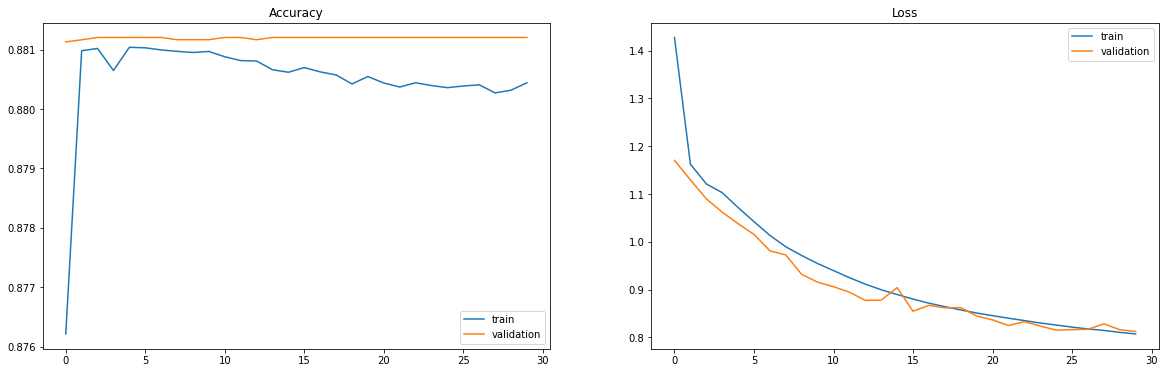

In [ ]:
model_plot_validation(history_gru_3)

In [ ]:
score = model_gru_3.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_gru_3.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.881029486656189
Training Loss:  0.7521082162857056
Testing Accuracy:  0.8812029957771301
Testing Loss:  0.8123355507850647


In this case the loss curve doesn't diverge. But we still could improve accuracy and loss. 
Next we will add a new GRU layer.


In [ ]:
model_gru_4 = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, lambda x : GRU(x), lambda x: GRU(x, return_sequences=True))

model_gru_4.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model_gru_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 512)           13571072  
_________________________________________________________________
gru (GRU)                    (None, 512)               1575936   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 53, 512)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 53, 512)           1575936   
_________________________________________________________________
dense (Dense)                (None, 53, 13731)         7044003   
Total params: 23,766,947
Trainable params: 23,766,947
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_gru_4 = fit_model(model_gru_4, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.GRU.4.30_jan_21')

Epoch 1/30
193/193 [==============================] - 163s 660ms/step - loss: 1.5044 - acc: 0.8566 - val_loss: 0.7844 - val_acc: 0.8886

Epoch 00001: val_loss improved from inf to 0.78436, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 129s 667ms/step - loss: 0.7837 - acc: 0.8886 - val_loss: 0.7390 - val_acc: 0.8920

Epoch 00002: val_loss improved from 0.78436 to 0.73904, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 128s 666ms/step - loss: 0.7055 - acc: 0.8941 - val_loss: 0.6749 - val_acc: 0.8967

Epoch 00003: val_loss improved from 0.73904 to 0.67486, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 129s 668ms/step - loss: 0.6434 - acc: 0.8993 - val_loss: 0.6132 - val_acc: 0.9033

Epoch 00004: val_loss improved from 0.67486 to 0.61321, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 129s 668ms/step - loss: 0.5797 - acc: 0.9061 - val_loss: 0.5862 - val_acc: 0.9050

Epoch 00005: val_loss improved from 0.61321 to 0.58620, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 129s 669ms/step - loss: 0.5230 - acc: 0.9117 - val_loss: 0.5288 - val_acc: 0.9108

Epoch 00006: val_loss improved from 0.58620 to 0.52881, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 129s 669ms/step - loss: 0.4718 - acc: 0.9167 - val_loss: 0.4898 - val_acc: 0.9154

Epoch 00007: val_loss improved from 0.52881 to 0.48979, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 129s 668ms/step - loss: 0.4273 - acc: 0.9215 - val_loss: 0.4653 - val_acc: 0.9186

Epoch 00008: val_loss improved from 0.48979 to 0.46525, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 129s 668ms/step - loss: 0.3899 - acc: 0.9257 - val_loss: 0.4367 - val_acc: 0.9216

Epoch 00009: val_loss improved from 0.46525 to 0.43674, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 129s 668ms/step - loss: 0.3594 - acc: 0.9295 - val_loss: 0.4199 - val_acc: 0.9232

Epoch 00010: val_loss improved from 0.43674 to 0.41986, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 129s 668ms/step - loss: 0.3306 - acc: 0.9333 - val_loss: 0.4075 - val_acc: 0.9251

Epoch 00011: val_loss improved from 0.41986 to 0.40753, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 12/30
193/193 [==============================] - 129s 668ms/step - loss: 0.3057 - acc: 0.9369 - val_loss: 0.3977 - val_acc: 0.9261

Epoch 00012: val_loss improved from 0.40753 to 0.39771, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 13/30
193/193 [==============================] - 129s 667ms/step - loss: 0.2825 - acc: 0.9403 - val_loss: 0.3927 - val_acc: 0.9271

Epoch 00013: val_loss improved from 0.39771 to 0.39270, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 14/30
193/193 [==============================] - 128s 666ms/step - loss: 0.2635 - acc: 0.9432 - val_loss: 0.3910 - val_acc: 0.9273

Epoch 00014: val_loss improved from 0.39270 to 0.39102, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 15/30
193/193 [==============================] - 129s 666ms/step - loss: 0.2444 - acc: 0.9465 - val_loss: 0.3867 - val_acc: 0.9281

Epoch 00015: val_loss improved from 0.39102 to 0.38674, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 16/30
193/193 [==============================] - 129s 666ms/step - loss: 0.2286 - acc: 0.9493 - val_loss: 0.3837 - val_acc: 0.9285

Epoch 00016: val_loss improved from 0.38674 to 0.38370, saving model to model.GRU.4.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.4.30_jan_21/assets


Epoch 17/30
193/193 [==============================] - 129s 667ms/step - loss: 0.2134 - acc: 0.9522 - val_loss: 0.3866 - val_acc: 0.9289

Epoch 00017: val_loss did not improve from 0.38370
Epoch 18/30
193/193 [==============================] - 128s 665ms/step - loss: 0.1974 - acc: 0.9552 - val_loss: 0.3887 - val_acc: 0.9297

Epoch 00018: val_loss did not improve from 0.38370
Epoch 19/30
193/193 [==============================] - 128s 665ms/step - loss: 0.1842 - acc: 0.9579 - val_loss: 0.3867 - val_acc: 0.9296

Epoch 00019: val_loss did not improve from 0.38370
Epoch 20/30
193/193 [==============================] - 128s 665ms/step - loss: 0.1707 - acc: 0.9605 - val_loss: 0.3884 - val_acc: 0.9297

Epoch 00020: val_loss did not improve from 0.38370
Epoch 21/30
193/193 [==============================] - 128s 666ms/step - loss: 0.1588 - acc: 0.9633 - val_loss: 0.3963 - val_acc: 0.9298

Epoch 00021: val_loss did not improve from 0.38370
Epoch 22/30
193/193 [==============================] - 

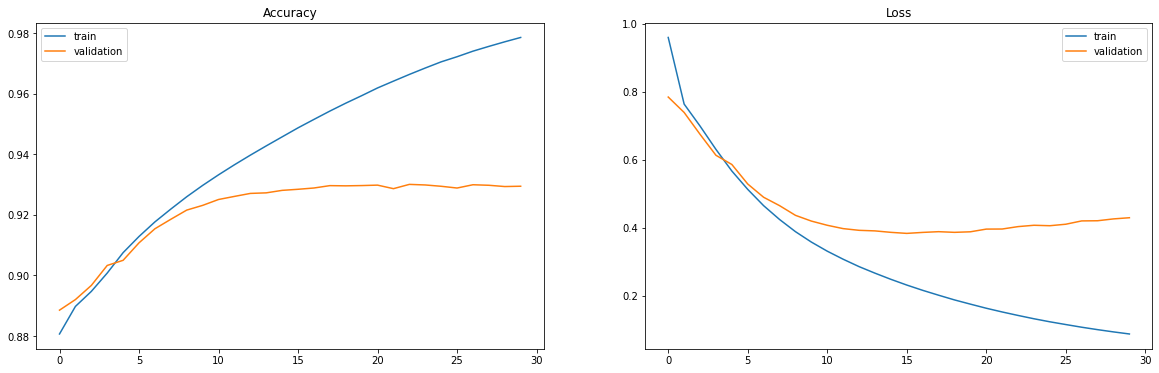

In [ ]:
model_plot_validation(history_gru_4)

In [ ]:
score = model_gru_4.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_gru_4.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.981244683265686
Training Loss:  0.07796963304281235
Testing Accuracy:  0.9294816255569458
Testing Loss:  0.429688960313797


As before, the model has improved but we have now overfitting, so let's add dropout to each GRU layer.


In [ ]:
model_gru_5 = build_model_with_dropout(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512, 
                                 lambda x : GRU(x), 
                                 lambda x: GRU(x, return_sequences=True),
                                 0.5)

model_gru_5.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
history_gru_5 = fit_model(model_gru_5, 
                           X = trainX, 
                           Y = trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           x_test = testX, y_test = testY,
                           epochs=30, batch_size=512, file_name = 'model.GRU.5.30_jan_21')

Epoch 1/30
193/193 [==============================] - 168s 686ms/step - loss: 1.5267 - acc: 0.8566 - val_loss: 0.7461 - val_acc: 0.8900

Epoch 00001: val_loss improved from inf to 0.74612, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 2/30
193/193 [==============================] - 136s 705ms/step - loss: 0.7585 - acc: 0.8897 - val_loss: 0.7082 - val_acc: 0.8939

Epoch 00002: val_loss improved from 0.74612 to 0.70822, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 3/30
193/193 [==============================] - 137s 709ms/step - loss: 0.7115 - acc: 0.8942 - val_loss: 0.6706 - val_acc: 0.8971

Epoch 00003: val_loss improved from 0.70822 to 0.67060, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 4/30
193/193 [==============================] - 137s 710ms/step - loss: 0.6687 - acc: 0.8978 - val_loss: 0.6273 - val_acc: 0.9016

Epoch 00004: val_loss improved from 0.67060 to 0.62726, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 5/30
193/193 [==============================] - 137s 710ms/step - loss: 0.6213 - acc: 0.9023 - val_loss: 0.5864 - val_acc: 0.9055

Epoch 00005: val_loss improved from 0.62726 to 0.58645, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 6/30
193/193 [==============================] - 137s 711ms/step - loss: 0.5855 - acc: 0.9055 - val_loss: 0.5525 - val_acc: 0.9091

Epoch 00006: val_loss improved from 0.58645 to 0.55247, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 7/30
193/193 [==============================] - 137s 710ms/step - loss: 0.5535 - acc: 0.9087 - val_loss: 0.5258 - val_acc: 0.9121

Epoch 00007: val_loss improved from 0.55247 to 0.52577, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 8/30
193/193 [==============================] - 137s 710ms/step - loss: 0.5261 - acc: 0.9113 - val_loss: 0.5033 - val_acc: 0.9145

Epoch 00008: val_loss improved from 0.52577 to 0.50332, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 9/30
193/193 [==============================] - 137s 709ms/step - loss: 0.5033 - acc: 0.9138 - val_loss: 0.4822 - val_acc: 0.9173

Epoch 00009: val_loss improved from 0.50332 to 0.48220, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 10/30
193/193 [==============================] - 137s 712ms/step - loss: 0.4827 - acc: 0.9157 - val_loss: 0.4668 - val_acc: 0.9188

Epoch 00010: val_loss improved from 0.48220 to 0.46679, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 11/30
193/193 [==============================] - 137s 709ms/step - loss: 0.4641 - acc: 0.9177 - val_loss: 0.4572 - val_acc: 0.9197

Epoch 00011: val_loss improved from 0.46679 to 0.45717, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 12/30
193/193 [==============================] - 137s 710ms/step - loss: 0.4496 - acc: 0.9194 - val_loss: 0.4536 - val_acc: 0.9186

Epoch 00012: val_loss improved from 0.45717 to 0.45362, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 13/30
193/193 [==============================] - 137s 711ms/step - loss: 0.4380 - acc: 0.9208 - val_loss: 0.4348 - val_acc: 0.9228

Epoch 00013: val_loss improved from 0.45362 to 0.43479, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 14/30
193/193 [==============================] - 137s 712ms/step - loss: 0.4250 - acc: 0.9222 - val_loss: 0.4262 - val_acc: 0.9235

Epoch 00014: val_loss improved from 0.43479 to 0.42621, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 15/30
193/193 [==============================] - 137s 710ms/step - loss: 0.4123 - acc: 0.9238 - val_loss: 0.4247 - val_acc: 0.9237

Epoch 00015: val_loss improved from 0.42621 to 0.42473, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 16/30
193/193 [==============================] - 137s 711ms/step - loss: 0.4041 - acc: 0.9247 - val_loss: 0.4162 - val_acc: 0.9252

Epoch 00016: val_loss improved from 0.42473 to 0.41617, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 17/30
193/193 [==============================] - 137s 710ms/step - loss: 0.3953 - acc: 0.9259 - val_loss: 0.4168 - val_acc: 0.9263

Epoch 00017: val_loss did not improve from 0.41617
Epoch 18/30
193/193 [==============================] - 137s 711ms/step - loss: 0.3885 - acc: 0.9268 - val_loss: 0.4064 - val_acc: 0.9271

Epoch 00018: val_loss improved from 0.41617 to 0.40643, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 19/30
193/193 [==============================] - 138s 713ms/step - loss: 0.3805 - acc: 0.9280 - val_loss: 0.4033 - val_acc: 0.9271

Epoch 00019: val_loss improved from 0.40643 to 0.40326, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 20/30
193/193 [==============================] - 138s 713ms/step - loss: 0.3717 - acc: 0.9291 - val_loss: 0.3982 - val_acc: 0.9277

Epoch 00020: val_loss improved from 0.40326 to 0.39822, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 21/30
193/193 [==============================] - 137s 711ms/step - loss: 0.3673 - acc: 0.9296 - val_loss: 0.3963 - val_acc: 0.9286

Epoch 00021: val_loss improved from 0.39822 to 0.39627, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 22/30
193/193 [==============================] - 137s 711ms/step - loss: 0.3607 - acc: 0.9307 - val_loss: 0.3927 - val_acc: 0.9290

Epoch 00022: val_loss improved from 0.39627 to 0.39272, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 23/30
193/193 [==============================] - 137s 710ms/step - loss: 0.3563 - acc: 0.9314 - val_loss: 0.3912 - val_acc: 0.9294

Epoch 00023: val_loss improved from 0.39272 to 0.39124, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 24/30
193/193 [==============================] - 137s 711ms/step - loss: 0.3488 - acc: 0.9323 - val_loss: 0.3885 - val_acc: 0.9293

Epoch 00024: val_loss improved from 0.39124 to 0.38852, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 25/30
193/193 [==============================] - 137s 709ms/step - loss: 0.3467 - acc: 0.9327 - val_loss: 0.3890 - val_acc: 0.9305

Epoch 00025: val_loss did not improve from 0.38852
Epoch 26/30
193/193 [==============================] - 137s 709ms/step - loss: 0.3411 - acc: 0.9336 - val_loss: 0.3869 - val_acc: 0.9292

Epoch 00026: val_loss improved from 0.38852 to 0.38694, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 27/30
193/193 [==============================] - 137s 710ms/step - loss: 0.3386 - acc: 0.9341 - val_loss: 0.3860 - val_acc: 0.9290

Epoch 00027: val_loss improved from 0.38694 to 0.38602, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 28/30
193/193 [==============================] - 137s 708ms/step - loss: 0.3334 - acc: 0.9347 - val_loss: 0.3847 - val_acc: 0.9303

Epoch 00028: val_loss improved from 0.38602 to 0.38466, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 29/30
193/193 [==============================] - 137s 708ms/step - loss: 0.3301 - acc: 0.9354 - val_loss: 0.3845 - val_acc: 0.9310

Epoch 00029: val_loss improved from 0.38466 to 0.38453, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Epoch 30/30
193/193 [==============================] - 137s 711ms/step - loss: 0.3267 - acc: 0.9358 - val_loss: 0.3817 - val_acc: 0.9311

Epoch 00030: val_loss improved from 0.38453 to 0.38173, saving model to model.GRU.5.30_jan_21


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


INFO:tensorflow:Assets written to: model.GRU.5.30_jan_21/assets


Training completed in time:  1:14:31.608775


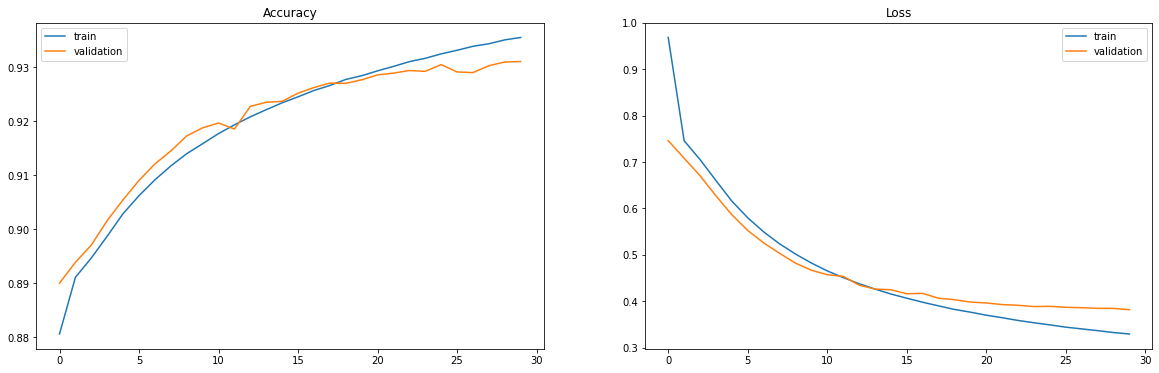

In [ ]:
model_plot_validation(history_gru_5)

In [ ]:
score = model_gru_5.evaluate(trainX, trainY, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model_gru_5.evaluate(testX, testY, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.9505126476287842
Training Loss:  0.24385343492031097
Testing Accuracy:  0.9310992360115051
Testing Loss:  0.38172584772109985


With this last model we have improved accuracy, loss and overfitting.


# Prediction

Let's load the best saved model to make predictions:

In [ ]:
model = load_model('model.lstm.4.30_jan_21')

In [ ]:
model_gru = load_model('model.GRU.5.30_jan_21')

Next, we do the predictions of a random set of test values:

In [ ]:
preds = model.predict_classes(testX[[1, 2, 5, 20, 50, 100, 300, 500, 1000, 5000, 10000, 23562, 24000]])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
preds_gru = model_gru.predict_classes(testX[[1, 2, 5, 20, 50, 100, 300, 500, 1000, 5000, 10000, 23562, 24000]])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Now we need to convert predicctions into text:

In [ ]:
def convert_prediction(preds):
  preds_text = []
  for i in preds:
      temp = []
      for j in range(len(i)):
          t = get_word(i[j], eng_tokenizer)
          if j > 0:
              if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                  temp.append('')
              else:
                  temp.append(t)
             
          else:
              if(t == None):
                  temp.append('')
              else:
                  temp.append(t)            
        
      preds_text.append(' '.join(temp))
  return preds_text

Here we may see the comparation from the expected value and the predicted one:

- GRU

In [ ]:
pd.DataFrame({'actual' : test.English.iloc[[1, 2, 5, 20, 50, 100, 300, 500, 1000, 5000, 10000, 23562, 24000]], 'predicted' : convert_prediction(preds_gru)})

,actual,predicted
50692,id like to have an answer,id like to a answer
16639,he is sure to come,is sure he come
98510,i was very tired so i went to bed early,i was very tired i went to bed
120757,do you think that you could help me weed the garden this afternoon,do you think you help me the this
20132,draw a small circle,draw a small
52208,tom forgot to lock his car,tom forgot to open his car
107894,the good news is that youre not going to die,the good news that going to
23452,you know everything,you know everything
54978,ill pick tom up in an hour,ill call tom up in an hour
119245,its difficult to help people who cant admit they need help,its difficult to help you cant help


- LSTM

In [ ]:
pd.DataFrame({'actual' : test.English.iloc[[1, 2, 5, 20, 50, 100, 300, 500, 1000, 5000, 10000, 23562, 24000]], 'predicted' : convert_prediction(preds)})

,actual,predicted
50692,id like to have an answer,id like to be an answer
16639,he is sure to come,he is that he will come
98510,i was very tired so i went to bed early,i was very tired i went to bed
120757,do you think that you could help me weed the garden this afternoon,do you think you should you in the
20132,draw a small circle,draw a big
52208,tom forgot to lock his car,tom forgot to car the car
107894,the good news is that youre not going to die,the good is that you going to
23452,you know everything,you know everything
54978,ill pick tom up in an hour,ill call tom in a hour
119245,its difficult to help people who cant admit they need help,its is to you help


# Conclusions


|   |Acc. Train | Acc. Test| Loss Train | Loss Test  |   Train Time |
|---|---|---|---|---|---|
|SimpleRNN| 92% | 91% |  0.41 |     0.49 | 44 min|
|LSTM|   94%|  93% |  0.25 |   0.38|  1h 13min|
|GRU| 95%  | 93%  | 0.24  |   0.38   | 1h 14min |

With a shadow of a doubt, the SimpleRNN is the worst one. As we already know this model wasn't good at processing long sentences.

Regarding LSTM and GRU models both seem to give the same result. Even though GRU layers does not perform well with long senteces. Probably we get the same result because we have a dataset in which the vast majority of sentences have between 2 and 9 words.
